Importing Libraries

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization 
from tensorflow.keras.layers import Dropout, Activation, Flatten
from tensorflow.keras.regularizers import l2
from keras.models import Sequential

from sklearn.metrics import classification_report, r2_score

In [0]:
kaggle competitions download -c digit-recognizer


In [2]:
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Basic visualising

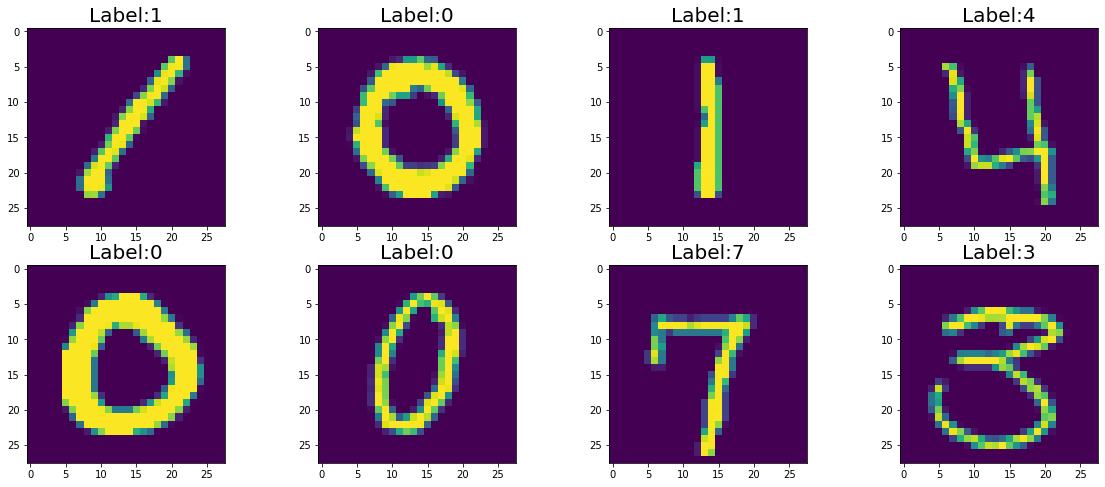

In [3]:
plt.figure(figsize=(20,8))
for i in range(10,18):
        
    arr = np.array(df.loc[i-10, "pixel0":])
    
    image = np.reshape(arr, (28,28))
    label = df.loc[i-10, "label"]
    
    plt.subplot(231+(i))
    plt.imshow(image) #cmap='gray'
    plt.title('Label:'+str(label),size=20)
    

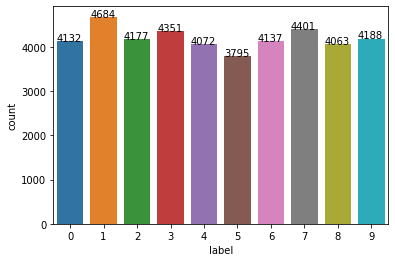

In [4]:
ax = sns.countplot(x="label", data=df)

for p in ax.patches:
    ax.annotate(text = p.get_height(), xy = (p.get_x(), p.get_height()+0.05))


In [5]:
df.isna().sum().sum()

0

In [6]:
X = df.drop("label", axis = 1)
y = df["label"]

Scale data

In [7]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X) #scaled df 

Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


Preprocessing - PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(0.95)
X_new = pca.fit_transform(X)
X_original = pca.inverse_transform(X_new)

pca.n_components_
# pca.explained_variance_ratio_.sum() = 0.95

320

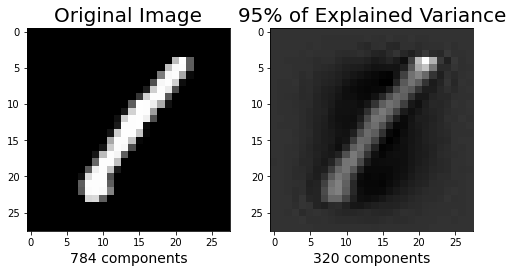

In [10]:
#visualising

plt.figure(figsize=(8,4));

k = 0
arr = np.array(df.loc[k, "pixel0":])

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(arr.reshape(28,28),
               interpolation='nearest', cmap='gray');
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(X_original[k].reshape(28, 28),
               interpolation='nearest', cmap='gray');
plt.xlabel('320 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);

Model creation

In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.99): # Experiment with changing this value
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True


In [16]:
model = tf.keras.models.Sequential([
    
    Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005)),
    Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu'),
    BatchNormalization(),
    
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2),
    Dropout(0.25),
    
    
    Conv2D(64, kernel_size = 3, strides = 1, activation = 'relu', input_shape = (28,28,1), kernel_regularizer = l2(0.0005)), 
    Conv2D(64, kernel_size = 3, strides = 1),
    BatchNormalization(),
    
    Activation('relu'),
    MaxPooling2D(pool_size = 2, strides = 2),
    Dropout(0.25),
    
    
    
    Flatten(),
    
    Dense(units = 256),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(units = 128),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(units = 84),
    BatchNormalization(),
    Activation('relu'),
    
    
    Dropout(0.25),
    Dense(10, activation = 'softmax')])
    


2022-03-09 16:10:07.728592: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
callbacks = myCallback()
#compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
X_train = X_train.reshape(33600,28,28,1)
X_test = X_test.reshape(8400,28,28,1)

# y_train = tf.keras.utils.to_categorical(y_train) #for non-sparse categorical crossentropy
# y_test = tf.keras.utils.to_categorical(y_test)

In [21]:
model.fit(X_train, y_train, epochs = 10, callbacks=[callbacks])

Epoch 1/10
1050/1050 [==============================] - 48s 44ms/step - loss: 0.2927 - accuracy: 0.9210
Epoch 2/10
1050/1050 [==============================] - 47s 45ms/step - loss: 0.1259 - accuracy: 0.9695
Epoch 3/10
1050/1050 [==============================] - 48s 46ms/step - loss: 0.1028 - accuracy: 0.9760
Epoch 4/10
1050/1050 [==============================] - 50s 47ms/step - loss: 0.0803 - accuracy: 0.9820
Epoch 5/10
1050/1050 [==============================] - 53s 51ms/step - loss: 0.0765 - accuracy: 0.9826
Epoch 6/10
1050/1050 [==============================] - 55s 53ms/step - loss: 0.0692 - accuracy: 0.9841
Epoch 7/10
1050/1050 [==============================] - 55s 52ms/step - loss: 0.0668 - accuracy: 0.9855
Epoch 8/10
1050/1050 [==============================] - 57s 54ms/step - loss: 0.0629 - accuracy: 0.9855
Epoch 9/10
1050/1050 [==============================] - 59s 56ms/step - loss: 0.0611 - accuracy: 0.9863
Epoch 10/10
1050/1050 [==============================] - 60s 57m

In [22]:
model.evaluate(X_test, y_test)

263/263 [==============================] - 3s 10ms/step - loss: 0.0395 - accuracy: 0.9920


[0.0394701212644577, 0.9920238256454468]

In [24]:
pred_probability = model.predict(X_test)
pred = np.argmax(pred_probability,axis=1) #predicted image labels

Viewing Predictions

In [25]:
print(classification_report(y_test, pred))
"R2 score: " + str(r2_score(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       816
           1       1.00      1.00      1.00       909
           2       1.00      0.99      0.99       846
           3       0.99      1.00      0.99       937
           4       0.99      0.99      0.99       839
           5       0.99      1.00      0.99       702
           6       0.98      0.99      0.99       785
           7       0.99      0.99      0.99       893
           8       1.00      0.99      0.99       835
           9       0.99      0.99      0.99       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



'R2 score: 0.9868519435387135'

View some incorrect predictions

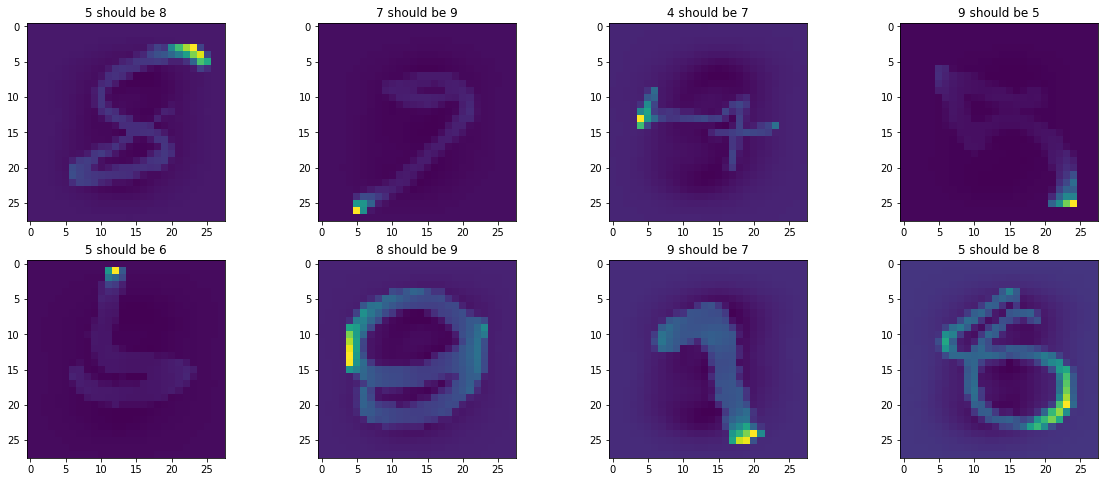

In [38]:
counter = 9
plt.figure(figsize=(20,8))
wrong_labels = []

for label_pred, label_true, image_arr in zip(pred, y_test, X_test):
    
    if label_pred != label_true:
        counter += 1
        wrong_labels.append(label_true)
        string = str(label_pred) + ' should be ' + str(label_true)

        plt.subplot(231+(counter))
        plt.imshow(image_arr.reshape(28,28)) #cmap='gray'
        plt.title(string)
        
    if counter == 17:
        break



In [27]:
counter-9

67

<AxesSubplot:ylabel='count'>

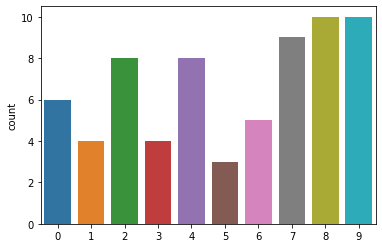

In [37]:
sns.countplot(x = wrong_labels)

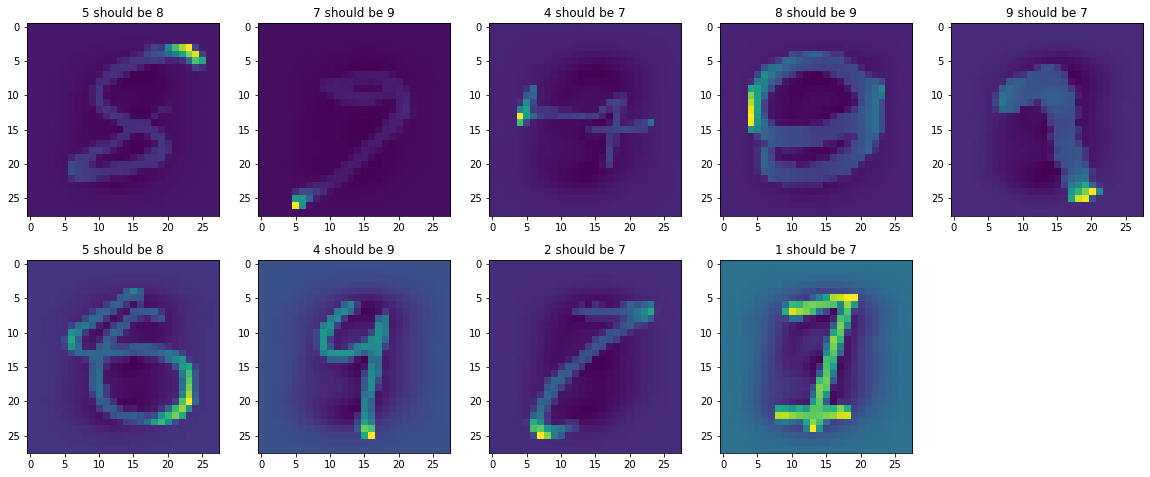

In [39]:
k = 9
plt.figure(figsize=(20,8))
wrong_labels = []

for label_pred, label_true, image_arr in zip(pred, y_test, X_test):
    
    if label_pred != label_true and label_true in [7,8,9]:
        k += 1
        wrong_labels.append(label_true)
        string = str(label_pred) + ' should be ' + str(label_true)

        plt.subplot(241+(k))
        plt.imshow(image_arr.reshape(28,28)) #cmap='gray'
        plt.title(string)
        
    if k == 18:
        break

